# Generalized method of moments

## 1

In [37]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import numpy.linalg as lin
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [38]:
# Load income data
pts = np.loadtxt('data/incomes.txt')

## a)

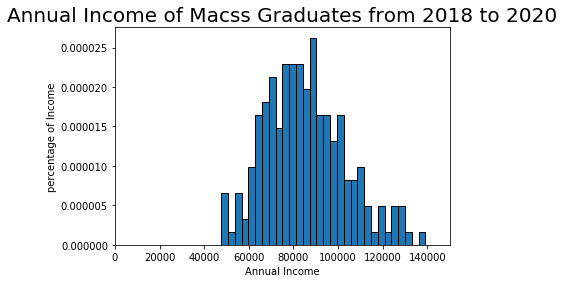

In [39]:
num_bins = 30
plt.hist(pts,num_bins,density=True,edgecolor = "k")
plt.title('Annual Income of Macss Graduates from 2018 to 2020', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('percentage of Income')
plt.xlim([1e-10, 150000])
plt.show()

## b)

In [40]:
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu)))
            
    pdf_vals = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) * np.exp(-(np.log(xvals) - mu)**2 / (2 * sigma**2))) / prob_notcut)
    
    return pdf_vals

In [41]:
# Defines the mean and standard deviation of income to be the two moments
def data_moments(xvals):

    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

# Calculate the two model moments for GMM, mean and standard deviation
def model_moments(mu, sigma, cut_lb, cut_ub):

    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)

# Calculate the vector of moment errors for GMM.
def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=True):
   
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

# Calculate the GMM weighted sum of squared moment errors of given paramters
def criterion(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [42]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts,1e-10, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
val_crit1 = results.fun

mean_data, std_data = data_moments(pts)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 1e-10, 150000)
err1 = err_vec(pts, mu_GMM1, sig_GMM1, 1e-10, 150000,False).reshape(2)

results

      fun: array([[6.39927135e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.14973880e-08, -2.93647111e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([11.33359961,  0.2132553 ])

Mu_GMM1 = 11.33359961340108, sigma_GMM1 = 0.21325529509280877
The value of the GMM criterion function at the estimated parameter values is [[6.39927135e-16]]
Mean of model = 85276.82405854971, standard deviation of model = 17992.541683009516
Mean of data = 85276.82360625811, standard deviation of data = 17992.542128046523
error of GMM = [ 5.30380448e-09 -2.47345263e-08]


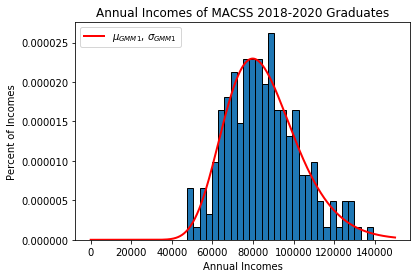

In [43]:
print('Mu_GMM1 = {}, sigma_GMM1 = {}'.format(mu_GMM1, sig_GMM1))
print('The value of the GMM criterion function at the estimated parameter values is {}'.format(val_crit1))
print('Mean of model = {}, standard deviation of model = {}'.format(mean_model, std_model))
print('Mean of data = {}, standard deviation of data = {}'.format(mean_data, std_data))
print('error of GMM =',err1)

# Histogram of the data
plt.hist(pts,num_bins,density=True,edgecolor = "k")

# PDF of estimated GMM
x = np.linspace(1e-10, 150000, 1000)
y = trunc_lognorm_pdf(x, mu_GMM1, sig_GMM1,1e-10, 150000)
plt.plot(x, y, linewidth=2,color='r',label= '$\mu_{GMM1}$, $\sigma_{GMM1}$')
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Incomes')
plt.title('Annual Incomes of MACSS 2018-2020 Graduates')
plt.legend(loc='upper left')
plt.show()

## c)

In [44]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = np.sqrt((mean_data - pts) ** 2) - std_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (np.sqrt((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat

In [45]:


Err_mat = get_Err_mat2(pts, mu_GMM1, sig_GMM1, 1e-10, 150000, False)
VCV2 = (1 / pts.shape[0]) * (Err_mat @ Err_mat.T)
print("The variance covariance matrix:\n", VCV2)
# I use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat = lin.pinv(VCV2)
print("The two-step estimator for \
the optimal weighting matrix:\n", W_hat)

The variance covariance matrix:
 [[0.04451671 0.02724079]
 [0.02724079 0.40593057]]
The two-step estimator for the optimal weighting matrix:
 [[23.42542598 -1.57201036]
 [-1.57201036  2.56896839]]


In [46]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (pts, 1e-10, 150000, W_hat)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
val_crit2 = results2.fun
mean_data, std_data = data_moments(pts)
mean_model, std_model = model_moments(mu_GMM2, sig_GMM2, 1e-10, 150000)
err2 = err_vec(pts, mu_GMM2, sig_GMM2, 1e-10, 150000,False).reshape(2)

results2

      fun: array([[2.6431068e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.19717242e-07, -1.25892773e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([11.33359961,  0.2132553 ])

Mu_GMM2 = 11.33359961340108, sigma_GMM2 = 0.21325529509280877
The value of the GMM criterion function at the estimated parameter values is [[2.6431068e-15]]
Mean of model = 85276.82405854971, standard deviation of model = 17992.541683009516
Mean of data = 85276.82360625811, standard deviation of data = 17992.542128046523
error of GMM = [ 5.30380448e-09 -2.47345263e-08]


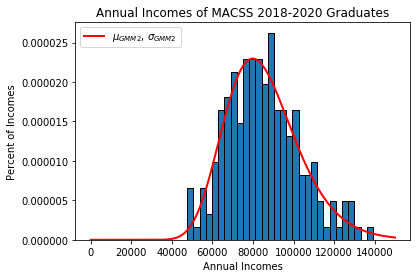

In [47]:
print('Mu_GMM2 = {}, sigma_GMM2 = {}'.format(mu_GMM2, sig_GMM2))
print('The value of the GMM criterion function at the estimated parameter values is {}'.format(val_crit2))
print('Mean of model = {}, standard deviation of model = {}'.format(mean_model, std_model))
print('Mean of data = {}, standard deviation of data = {}'.format(mean_data, std_data))
print('error of GMM =',err2)

# Histogram of the data
plt.hist(pts,num_bins,density=True,edgecolor = "k")

# PDF of estimated GMM
x = np.linspace(1e-10, 150000, 1000)
y = trunc_lognorm_pdf(x, mu_GMM2, sig_GMM2,1e-10, 150000)
plt.plot(x, y, linewidth=2,color='r',label= '$\mu_{GMM2}$, $\sigma_{GMM2}$')
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Incomes')
plt.title('Annual Incomes of MACSS 2018-2020 Graduates')
plt.legend(loc='upper left')
plt.show()

## d)

In [48]:
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals<=100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals>100000].shape[0] / xvals.shape[0]
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 1e-10, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma,cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    return crit_val


mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat1_3 = np.eye(3)
gmm_args = (pts, 1e-10, 150000, W_hat1_3)
results3 = opt.minimize(criterion3, params_init, args=(gmm_args),tol=1e-14, 
                         method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM3, sig_GMM3 = results3.x
val_crit3 = results3.fun
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(pts)
pert1, pert2, pert3 = model_moments3(mu_GMM3, sig_GMM3, 1e-10, 150000)
err3 = err_vec3(pts, mu_GMM3, sig_GMM3, 1e-10, 150000,False).reshape(3)

results3

      fun: array([[1.82839354e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.72507540e-07, 7.61449882e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 147
      nit: 22
   status: 0
  success: True
        x: array([11.33670518,  0.21151352])

Mu_GMM3 = 11.33670518110009, sigma_GMM3 = 0.2115135158429933
The value of the GMM criterion function at the estimated parameter values is [[1.82839354e-15]]
error of GMM = [ 4.17272568e-09  1.36228635e-08 -4.03162435e-08]
                      Data Moments  Model Momets
Percent <75000                 0.3           0.3
Percent 75000~100000           0.5           0.5
Percent >=100000               0.2           0.2


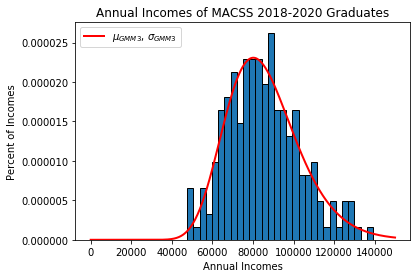

In [49]:
print('Mu_GMM3 = {}, sigma_GMM3 = {}'.format(mu_GMM3, sig_GMM3))
print('The value of the GMM criterion function at the estimated parameter values is {}'.format(val_crit3))
print('error of GMM =',err3)

matrix=pd.DataFrame({'Data Moments':[bpct_1_dat, bpct_2_dat, bpct_3_dat],
                'Model Momets':[pert1, pert2, pert3]},
                index=['Percent <75000','Percent 75000~100000','Percent >=100000'])
print(matrix)

# Histogram of the data
plt.hist(pts,num_bins,density=True,edgecolor = "k")

# PDF of estimated GMM
x = np.linspace(1e-10, 150000, 1000)
y = trunc_lognorm_pdf(x, mu_GMM3, sig_GMM3,1e-10, 150000)
plt.plot(x, y, linewidth=2,color='r',label= '$\mu_{GMM3}$, $\sigma_{GMM3}$')
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Incomes')
plt.title('Annual Incomes of MACSS 2018-2020 Graduates')
plt.legend(loc='upper left')
plt.show()

## e)

In [50]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts <= 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts > 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts <= 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts > 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    return Err_mat

Err_mat3 = get_Err_mat3(pts, mu_GMM3, sig_GMM3, 1e-10, 150000, False)
VCV2_3 = (1 / pts.shape[0]) * (Err_mat3 @ Err_mat3.T)
print("The variance covariance matrix:\n", VCV2_3)
# I use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3)
print("The two-step estimator for \
the optimal weighting matrix:\n", W_hat2_3)

The variance covariance matrix:
 [[ 2.33333331 -0.99999998 -1.00000004]
 [-0.99999998  0.99999997 -1.00000003]
 [-1.00000004 -1.00000003  4.00000032]]
The two-step estimator for the optimal weighting matrix:
 [[ 0.25761773 -0.14958449 -0.01246537]
 [-0.14958449  0.11911357 -0.0734072 ]
 [-0.01246537 -0.0734072   0.20221605]]


In [51]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
gmm_args = (pts, 1e-10, 150000, W_hat2_3)
results4 = opt.minimize(criterion3, params_init, args=(gmm_args),tol=1e-14,
                          method='L-BFGS-B', bounds=((1e-10, None), (1e-2, None)))
mu_GMM4, sig_GMM4 = results4.x
params = np.array([mu_GMM4, sig_GMM4])
val_crit4 = results4.fun
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(pts)
pert1, pert2, pert3 = model_moments3(mu_GMM4, sig_GMM4,1e-10, 150000)
err4 = err_vec3(pts, mu_GMM4, sig_GMM4, 1e-10, 150000, False).reshape(1,3)
results4

      fun: array([[8.00625276e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.65814477e-11, 1.00337868e-11])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 90
      nit: 19
   status: 0
  success: True
        x: array([11.33670518,  0.21151352])

In [52]:
print('Mu_GMM4 = {}, sigma_GMM4 = {}'.format(mu_GMM4, sig_GMM4))
print('The value of the GMM criterion function at the estimated parameter values is {}'.format(val_crit4))
print('error of GMM =',err4)
mm=pd.DataFrame({'Data Moments':[bpct_1_dat, bpct_2_dat, bpct_3_dat],
                'Model Moments':[pert1, pert2, pert3]},
                index=['Percent <75000','Percent 75000~100000','Percent >=100000'])
print(mm)


Mu_GMM4 = 11.33670517923623, sigma_GMM4 = 0.211513515047493
The value of the GMM criterion function at the estimated parameter values is [[8.00625276e-16]]
error of GMM = [[ 1.19268828e-08  1.54472575e-08 -5.65084640e-08]]
                      Data Moments  Model Moments
Percent <75000                 0.3            0.3
Percent 75000~100000           0.5            0.5
Percent >=100000               0.2            0.2


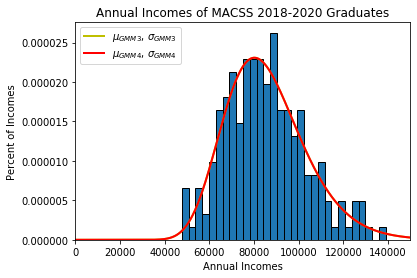

In [53]:
num_bins = 30
plt.hist(pts, num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1e-10, 150000])
x = np.linspace(1e-10, 150000, 1000)
# Plot the estimated GMM PDF using three moments with identity matrix
y1 =trunc_lognorm_pdf(x, mu_GMM3, sig_GMM3,1e-10, 150000)
y2 = trunc_lognorm_pdf(x, mu_GMM4, sig_GMM4,1e-10, 150000)
plt.plot(x, y1, linewidth=2,color='y',label= '$\mu_{GMM3}$, $\sigma_{GMM3}$')
plt.plot(x, y2, linewidth=2,color='r',label= '$\mu_{GMM4}$, $\sigma_{GMM4}$')
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Incomes')
plt.title('Annual Incomes of MACSS 2018-2020 Graduates')
plt.legend(loc='upper left')
plt.show()

## f)

In [54]:
mu=[mu_GMM1,mu_GMM2,mu_GMM3,mu_GMM4]
sig=[sig_GMM1,sig_GMM2,sig_GMM3,sig_GMM4]
GMMV=[results.fun,results2.fun,results3.fun,results4.fun]

In [55]:
pd.DataFrame({"mu":mu,"sigma":sig,"GMM Fn Value":GMMV},
            index=['2 moments with Identity Matrix','2 moments with Weighted Matrix',
                   '3 moments with Identity Matrix','3 moments with Weighted Matrix']).astype(float)

,mu,sigma,GMM Fn Value
2 moments with Identity Matrix,11.333600,0.213255,6.399271e-16
2 moments with Weighted Matrix,11.333600,0.213255,2.643107e-15
3 moments with Identity Matrix,11.336705,0.211514,1.828394e-15
3 moments with Weighted Matrix,11.336705,0.211514,8.006253e-16


By comparing the criterion function value, the 2 moments with identity matrix fit the data most.

## 2

In [56]:
df2 = pd.read_csv('data/sick.txt',sep=',', skiprows = 1, names=["sick","age","children","avgtemp_winter"])
df2.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [57]:
def err_vec(y,x1,x2,x3,beta0,beta1,beta2,beta3,simple=True):
    betaX = beta0 + beta1*x1 + beta2*x2 + beta3*x3
    if simple:
        return betaX - y
    else:
        return (betaX-y)/y
def criterion(params,*args):
    beta0,beta1,beta2,beta3 = params
    y,x1,x2,x3,W = args
    err = err_vec(y,x1,x2,x3,beta0,beta1,beta2,beta3)
    crit_val = err.T @ W @ err
    return crit_val

In [58]:
params_init = np.array([1,0,0,0])
W_hat = np.eye(200)
gmm_args = (df2.sick, df2.age, df2.children, df2.avgtemp_winter, W_hat)
res = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,method='L-BFGS-B')
val_crit = res.fun
beta0, beta1, beta2, beta3 = res.x

In [59]:
print("Estimate of b0 :",beta0)
print("Estimate of b1 :",beta1)
print("Estimate of b2 :",beta2)
print("Estimate of b3 :",beta3)
print("GMM criterion function:",val_crit)

Estimate of b0 : 0.2516448636180223
Estimate of b1 : 0.012933469667256711
Estimate of b2 : 0.40050098511048643
Estimate of b3 : -0.009991708483433188
GMM criterion function: 0.00182128980560192
